<!-- Copyright 2023 Sidney Radcliffe

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License. -->

<!-- Warning, README.md is autogenerated from README.ipynb, do not edit it directly -->


`pip install make_agents`
 
<p align="center">
  <img src="README_files/make_agents_logo.jpg" width=256>
</p>

# MakeAgents 

MakeAgents is a micro framework for creating LLM-driven agents.

The MakeAgents paradigm is to define an agent's behaviour and capabilities entirely through **action functions**, and an **action graph**.

Currently supports OpenAI's GPT chat models out of the box.

## Setup

- Install `make_agents` using your package manager, e.g. `pip install make_agents`
- Set the `OPENAI_API_KEY` environment variable, with your [OpenAI api key](https://help.openai.com/en/articles/4936850-where-do-i-find-my-secret-api-key).
    - Alternatively, `import openai` and set `openai.api_key = ...`
- See the examples below, and the reference docs.

## Examples

### Example 1: A conversational agent tasked with getting the user's name

In [1]:
import json
from IPython.display import display, Markdown
from pydantic import BaseModel, Field
import make_agents as ma

#### Action function, `message_user`

An action function must have at most one argument, and that argument must be annotated with a Pydantic model. 
The function's name, its docstring, and the Pydantic model, is provided to the LLM, and should be considered as part of the promping strategy.
It's not recommended to annotate the arg in the docstring, since it is done via the Pydantic model already.

This action function allows the agent to message the user, and get a response.

In [2]:
class MessageUserArg(BaseModel):
    message: str = Field(description="Message to send user")


@ma.action
def message_user(arg: MessageUserArg):
    """Send the user a message, and get their response."""
    response = ""
    while response == "":
        response = input(arg.message).strip()
    return response

### Action graph

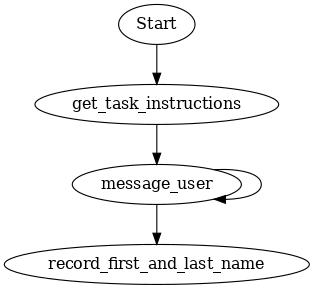

### Agent execution log

call `get_task_instructions`: <no arguments>

`get_task_instructions` result: "Your task is to get both the user's first and last name."

call `message_user`: {
  "message": "Hello, may I have your first name please?"
}

`message_user` result: "Sure, it's Bill"

call `select_next_func`: {
  "thought_process": "I have obtained the user's first name, now I need to get their last name. So, I will call the 'message_user' function again to request for their last name.",
  "next_function": "message_user"
}

`select_next_func` result: "message_user"

call `message_user`: {
  "message": "Nice to meet you, Bill. Could you please tell me your last name as well?"
}

`message_user` result: "BoBaggins"

call `select_next_func`: {
  "thought_process": "Now that I have both the first and last name of the user, the next step is to record both. I will accomplish this task by calling the 'record_first_and_last_name' function.",
  "next_function": "record_first_and_last_name"
}

`select_next_func` result

In [3]:
# Define the remaining action functions.


@ma.action
def get_task_instructions():
    return "Your task is to get both the user's first and last name."


class LogNameArg(BaseModel):
    first_name: str = Field(description="User's first name")
    last_name: str = Field(description="User's last name")


@ma.action
def record_first_and_last_name(arg: LogNameArg):
    """Record the users first and last name."""
    return {"first_name": arg.first_name, "last_name": arg.last_name}


# Then define action graph
action_graph = {
    ma.Start: [get_task_instructions],
    get_task_instructions: [message_user],
    message_user: [message_user, record_first_and_last_name],
}
display(Markdown("### Action graph"))
display(ma.bonus.draw_graph(action_graph))

# Finally, run the agent
display(Markdown("### Agent execution log"))
for messages in ma.run_agent(action_graph):
    ma.bonus.pretty_print(messages[-1])  # print most recent message on stack
print(f"Retrieved user_name: {json.loads(messages[-1]['content'])}")

### Example 2: A system assistant <span style="color:red"> — _dangerous_</span>

In this example, the agent is allowed to run bash commands on your system, and read the results... Validation is implemented, so please make sure you understand the command before allowing it to run.

In [4]:
import subprocess
import shlex

### Action graph

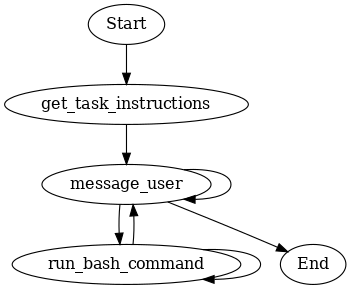

### Agent execution log

call `get_task_instructions`: <no arguments>

`get_task_instructions` result: "Your task is help the user with their computer system, until they ask to end the chat. Please give the user only the relevant information."

call `message_user`: {
  "message": "Hello! How may I assist you with your computer system today?"
}

`message_user` result: "Hi, how much space do I have left on my hard drive?"

call `select_next_func`: {
  "thought_process": "To check the available space on the user's hard drive, I can utilize the bash command 'df -h'. Therefore, the 'run_bash_command' function should be the next one to use.",
  "next_function": "run_bash_command"
}

`select_next_func` result: "run_bash_command"

call `run_bash_command`: {
  "plan": "To check the available space on the hard drive",
  "command": "df -h"
}

`run_bash_command` result: {"stout": "Filesystem      Size  Used Avail Use% Mounted on\nudev            7.8G     0  7.8G   0% /dev\ntmpfs           1.6G  2.0M  1.6G   1% /run\n/dev/

In [5]:
@ma.action
def get_task_instructions():
    return "Your task is help the user with their computer system, until they ask to end the chat. Please give the user only the relevant information."


class RunBashCommandArg(BaseModel):
    plan: str = Field(description="Plan what to run")
    command: str = Field(description="Command to run")


@ma.action
def run_bash_command(arg: RunBashCommandArg):
    """Record the users first and last name."""
    result = subprocess.run(shlex.split(arg.command), capture_output=True, text=True)
    return {"stout": result.stdout, "stderr": result.stderr}


# Define action graph
action_graph = {
    ma.Start: [get_task_instructions],
    get_task_instructions: [message_user],
    message_user: [message_user, run_bash_command, ma.End],
    run_bash_command: [message_user, run_bash_command],
}
display(Markdown("### Action graph"))
display(ma.bonus.draw_graph(action_graph))

# Run the agent
display(Markdown("### Agent execution log"))
for messages in ma.run_agent(action_graph):
    ma.bonus.pretty_print(messages[-1])
    if messages[-1].get("function_call", {}).get("name", "") == run_bash_command.__name__:
        command = json.loads(messages[-1]["function_call"]["arguments"])["command"]
        input(
            f"Please validate the bash command, before pressing enter to continue. Command: `{command}`"
        )

### Example 3: A dynamic action graph to carry out validation before making actions accessible

In [6]:
@ma.action
def get_task_instructions():
    return "Get the users email address, and validate it."


class SendValidationEmailArg(BaseModel):
    users_email_address: str = Field(description="The users email address")


@ma.action
def send_validation_email(arg: SendValidationEmailArg):
    """Send the user a validation email."""
    if not arg.users_email_address.endswith(".com"):
        return {"status": "error", "description": "Email address must end with `.com`"}
    else:
        return {"status": "success", "description": "Validation code sent"}


class CheckValidationCodeArg(BaseModel):
    validation_code: str = Field(description="The validation code (6 digits)")


@ma.action
def check_validation_code(arg: CheckValidationCodeArg):
    """Send the user a validation email."""
    if len(arg.validation_code) != 6:
        return {"status": "error", "description": "Validation code must be 6 digits"}
    elif arg.validation_code == "123456":
        return {"status": "success", "description": "Validation code correct"}
    else:
        return {"status": "error", "description": "Validation code incorrect"}


def action_graph(current_action: callable, current_action_result: dict) -> list[callable]:
    """Return the next action(s) to run, given the current action and its result."""
    if current_action == ma.Start:
        return [get_task_instructions]
    elif current_action == get_task_instructions:
        return [message_user]
    elif current_action == message_user:
        return [message_user, send_validation_email, check_validation_code]
    elif current_action == send_validation_email:
        if current_action_result["status"] == "success":
            return [message_user]
        else:
            return [message_user, send_validation_email]
    elif current_action == check_validation_code:
        if current_action_result["status"] == "success":
            return [ma.End]
        else:
            return [message_user, check_validation_code]
    else:
        raise ValueError(f"Unknown action: {current_action}")


# We lose the ability to plot the graph when using a function to define the action graph.

# Run the agent
display(Markdown("### Agent execution log"))
for messages in ma.run_agent(action_graph):
    ma.bonus.pretty_print(messages[-1])

### Agent execution log

call `get_task_instructions`: <no arguments>

`get_task_instructions` result: "Get the users email address, and validate it."

call `message_user`: {
  "message": "Could you please share your email address?"
}

`message_user` result: "sure, it's bob@bill.io"

call `select_next_func`: {
  "thought_process": "Now that I have the users email, I can proceed to validate it. The best function to use for this is 'send_validation_email'.",
  "next_function": "send_validation_email"
}

`select_next_func` result: "send_validation_email"

call `send_validation_email`: {
  "users_email_address": "bob@bill.io"
}

`send_validation_email` result: {"status": "error", "description": "Email address must end with `.com`"}

call `select_next_func`: {
  "thought_process": "The validation email could not be sent because the users email address does not end with '.com'. I will ask the user to provide a valid email address",
  "next_function": "message_user"
}

`select_next_func` result: "message_user"

call 

### Notes:

- Prompting has a big impact on the performance of the agent. Action function names, Pydantic models and docstrings can all be considered part of the prompting strategy.
- The current preferred way to deal with exceptions due to the model not providing correct function args is to modify the prompts / action graph, to reduce the error rate.
- "gpt-4" is used by default, and performs better than "gpt-3.5-turbo", (at least with the current set up and prompts).


### Contributing

- For any ideas/comments/suggestions, create a GitHub issue, or comment in a relevant issue.
- For the development of the framework itself, the aspiration is take an "example driven" development approach. 
    I.e. find compelling examples where a feature / change would be helpful before adding it.

### Dev setup

- Clone the repo and `cd` into it
- Run `poetry install`
- Run `poetry run pre-commit install`
